# Axes in Anndata and MuData

As explained in the introduction to `AnnData`, we usually work with tabular or matrix formats.
In the `AnnData` convention, we store observations (samples or cells) in rows and variables (genes, proteins, atac regions, etc ...) in columns.
Both the rows and columns of this matrix are indexed, which allows us to link between each other the structured layers of the AnnData object. 

When we interact with both axes of these matrices, we modify the same axes on all the linked layers.

In scRNA-seq data, each row corresponds to a cell with a barcode, and each column corresponds to a gene with a gene id. 

In this tutorial we will showcase operations on AnnData objects storing each one independent view of the same scRNAseq matrix (and accompanying metadata) and show how different choices of processing workflows can be stored in the same MuData object.


In [1]:
import warnings

import numpy as np
import scanpy as sc
from mudata import MuData
from scipy.stats import median_abs_deviation

warnings.simplefilter(action="ignore", category=FutureWarning)

np.random.seed(1979)

First, we need to import the raw data for a dataset of our choice. We use mudatasets package that conveniently collects some useful 10X single cell datasets that are publicly available. For this example we need a multimodal dataset, so select the *citeseq 5k* dataset, a collection of healthy PBMCs for which 2 modalities were profiled, RNA and PROTEINS.


In [2]:
import mudatasets as mds

mds.list_datasets()

['pbmc10k_multiome',
 'brain9k_multiome',
 'brain3k_multiome',
 'pbmc5k_citeseq',
 'pbmc3k_multiome']

In [3]:
mds.info("pbmc5k_citeseq")

{'name': 'pbmc5k_citeseq',
 'version': '1.0.0',
 'total_size': '418.1MiB',
 'files': [{'name': 'filtered_feature_bc_matrix.h5',
   'url': 'https://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5',
   'md5': '3366a47283177fe9af143d5819fad61f',
   'format': '10x_h5',
   'size': 17129253,
   'raw': True},
  {'name': 'minipbcite.h5mu',
   'url': 'https://github.com/gtca/h5xx-datasets/blob/main/datasets/minipbcite.h5mu?raw=true',
   'md5': '6dc66fc56970193ad498b8eb5d96306c',
   'size': 17151496,
   'raw': False,
   'subsampled': True,
   'subsample_fraction': 0.1,
   'selected_features': True},
  {'name': 'pbmc5k_citeseq_processed.h5mu',
   'url': 'https://osf.io/9yexr/download',
   'md5': '79317dcb69368acc43954eeb04125e1f',
   'size': 404121662,
   'raw': False,
   'processed': True,
   'subsampled': False,
   'selected_features': True}],
 'data_versions': [{'name': 'pbmc5k_citeseq',
   'version': '1.0.0',
   'total_size': '418.

In [4]:
pbmc5k = mds.load("pbmc5k_citeseq", files=["filtered_feature_bc_matrix.h5"])

  0%|          | 0/2091 [00:00<?, ?it/s, 16.3MiB, filtered_feature_bc_matrix.h5, pbmc5k_citeseq]

  1%|          | 17/2091 [00:00<00:14, 146.10it/s, 16.3MiB, filtered_feature_bc_matrix.h5, pbmc5k_citeseq]

  4%|▍         | 93/2091 [00:00<00:04, 441.46it/s, 16.3MiB, filtered_feature_bc_matrix.h5, pbmc5k_citeseq]

 18%|█▊        | 386/2091 [00:00<00:01, 1409.76it/s, 16.3MiB, filtered_feature_bc_matrix.h5, pbmc5k_citeseq]

 49%|████▉     | 1023/2091 [00:00<00:00, 2464.90it/s, 16.3MiB, filtered_feature_bc_matrix.h5, pbmc5k_citeseq]

 87%|████████▋ | 1816/2091 [00:00<00:00, 3548.87it/s, 16.3MiB, filtered_feature_bc_matrix.h5, pbmc5k_citeseq]

100%|██████████| 2091/2091 [00:00<00:00, 2626.60it/s, 16.3MiB, filtered_feature_bc_matrix.h5, pbmc5k_citeseq]


/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
  warn("Dataset is in the 10X .h5 format and can't be loaded as backed.")


/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


■ Loading filtered_feature_bc_matrix.h5...


/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/anndata/_core/anndata.py:1813: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/anndata/_core/anndata.py:1813: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/mudata/_core/mudata.py:947: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


In [5]:
pbmc5k

MuData object with n_obs × n_vars = 5247 × 33570
  var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
  2 modalities
    rna:	5247 x 33538
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    prot:	5247 x 32
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

## Storing different preprocessing choices in one MuData object

`MuData` is a convenient container for collections of anndata objects. If you are in two minds about processing your data, you can store different anndata that result from applying different processing strategies in the same `MuData`. 
Let's focus on the RNA modality alone for this part of the tutorial. To do so, we fetch the respective anndata from the pbmc5k object we have just created.

*NB if you have a local `MuData` in storage you could also directly read the RNA modality alone by fetching the relevant slot in the h5 file, by doing `mu.read(inputpath + "/rna")`*

In [6]:
rna_raw = pbmc5k["rna"].copy()
rna_raw

/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/anndata/_core/anndata.py:1813: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 5247 × 33538
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

Now we start working on this scRNAseq dataset.
For the sake of this tutorial we will apply a minimal workflow, but for a more detailed QC including background correction and doublet detection, we refer the reader to the best practices book and [paper] (https://www.nature.com/articles/s41576-023-00586-w). 

We start by creating the relevant metadata in the anndata `.var` slot, here by flagging Ribosomal, Mitochondrial and Haemoglobin genes and calculating their percentage for each cell.

In [7]:
rna_raw.var_names_make_unique()
rna_raw.var["mt"] = rna_raw.var_names.str.startswith("MT-")
# ribosomal genes
rna_raw.var["ribo"] = rna_raw.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
rna_raw.var["hb"] = rna_raw.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(rna_raw, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

In [8]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

Let's showcase 3 alternative filtering choices:

1. We apply a permissive filtering, flagging as failing QC ("outliers") the cells that exceed the threshold of 5 median absolute deviations on the cell distribution for each of the defined covariates. 

In [9]:
rna_raw.obs["outlier"] = (
    is_outlier(rna_raw, "log1p_total_counts", 5)
    | is_outlier(rna_raw, "log1p_n_genes_by_counts", 5)
    | is_outlier(rna_raw, "pct_counts_in_top_20_genes", 5)
)
rna_raw.obs.outlier.value_counts()

outlier
False    4255
True      992
Name: count, dtype: int64

another more stringent choice instead: 

2. Flag the cells that have mt% higher than 3 MADs 

In [10]:
rna_raw.obs["mt_outlier"] = is_outlier(rna_raw, "pct_counts_mt", 3)
rna_raw.obs.mt_outlier.value_counts()

mt_outlier
False    4062
True     1185
Name: count, dtype: int64

Finally, we can also decide to filter based on a predefined threshold. 

3. Let's say we want to flag the cells that have more than 10% mitochondrial genes.

In [11]:
rna_raw.obs["pct_mt_10"] = rna_raw.obs["pct_counts_mt"] > 10
rna_raw.obs.pct_mt_10.value_counts()

pct_mt_10
False    3154
True     2093
Name: count, dtype: int64

As you can see, the 3 filtering choices give very different results: in each case, a different number of cells would be excluded for quality purpouses. Let's say we would like to keep 2 versions of the dataset, one with a less permissive thr and one with more stringent filtering criteria:

In [12]:
print(f"Total number of cells: {rna_raw.n_obs}")
rna_a = rna_raw[(~rna_raw.obs.outlier) & (~rna_raw.obs.mt_outlier)].copy()
print(f"Number of cells after filtering genes by 5 MADs and %mt by 3 MADS: {rna_a.n_obs}")

rna_b = rna_raw[(~rna_raw.obs.outlier) & (~rna_raw.obs.pct_mt_10)].copy()
print(f"Number of cells after filtering genes by 5 MADs and 10 %mt: {rna_b.n_obs}")

Total number of cells: 5247
Number of cells after filtering genes by 5 MADs and %mt by 3 MADS: 4043
Number of cells after filtering genes by 5 MADs and 10 %mt: 3142


We also want to store the information about which cells were in the alternative processing applied in the second anndata, for future exploration.

In [13]:
rna_a.obs["cells_selection_alt"] = [x in rna_b.obs_names for x in rna_a.obs_names]

Now we apply some filtering on the feature space, by removing in both cases genes that are expressed in less than 20 cells

In [14]:
print(f"Total number of genes: {rna_raw.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(rna_a, min_cells=20)
print(f"Number of genes in rna_a object: {rna_a.n_vars}")

sc.pp.filter_genes(rna_b, min_cells=20)
print(f"Number of genes in rna_b object: {rna_b.n_vars}")

Total number of genes: 33538


Number of genes in rna_a object: 13342


Number of genes in rna_b object: 12946


In [15]:
def classicnorm(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

In [16]:
def highlyvar(adata, flavor: str, ngenes=None, min_mean=0.02, max_mean=4, min_disp=0.5):
    if flavor == "seurat_v3":
        if ngenes is not None:
            sc.pp.highly_variable_genes(adata, flavor=flavor, n_top_genes=int(ngenes))
    else:
        sc.pp.highly_variable_genes(adata, flavor=flavor, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)

We apply the same normalization `log1p` on size_factor normalized counts, and also highly variable genes selection.

In [17]:
classicnorm(rna_a)
highlyvar(rna_a, flavor="seurat", min_mean=0.02, max_mean=4, min_disp=0.5)

In [18]:
classicnorm(rna_b)
highlyvar(rna_b, flavor="seurat", min_mean=0.02, max_mean=4, min_disp=0.5)

In [19]:
np.sum(rna_a.var.highly_variable)

np.int64(1945)

As you can see, these 2 processed objects gave us different HVG subsets, even if the normalization and the selection of the features were exactly the same. 

In [20]:
np.sum(rna_b.var.highly_variable)

np.int64(1897)

We have done some minimal preprocessing work now and created alternative versions of the same underlying scRNAseq data. We would like to store these alternative choices in the same place, to explore different processing downstream and for future reference and better project management. 
`MuData` can help us do so, leveraging the functionality of `axes` when creating a final object.
Until now, we have 3 individual anndata: 
the raw andata `rna_raw` with 
the 2 version of the preprocessing that we applied, `rna_a` and `rna_b`.


## Axes conventions

The convention of axes in `MuData` follows the AnnData structure that we briefly mentioned before. On rows (`axis=0`) we have observations, or cell names, on columns (`axis=1`) we have features.



In the original raw mudata that we dowloaded, the rna and the prot anndatas were concatenated on the `axis=0`, which is the default when you have the same observations but different vars. In this case the features are different because we have proteins and genes for the same cells. Indeed we see that the number of cells in the Mudata is `5247` but the `vars` are `32 + 33538 = 33570` :

In [21]:
pbmc5k

MuData object with n_obs × n_vars = 5247 × 33570
  var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
  2 modalities
    rna:	5247 x 33538
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    prot:	5247 x 32
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

but our 3 rna anndata have different dimensions, even though they represent different manipulations of the same underlying sc data.

In [22]:
print(f"Total number of cells {rna_raw.n_obs} and genes {rna_raw.n_vars} for raw rna anndata")
print(f"Total number of cells {rna_a.n_obs} and genes {rna_a.n_vars} for preprocessed rna_a anndata")
print(f"Total number of cells {rna_b.n_obs} and genes {rna_b.n_vars} for preprocessed rna_a anndata")

Total number of cells 5247 and genes 33538 for raw rna anndata
Total number of cells 4043 and genes 13342 for preprocessed rna_a anndata
Total number of cells 3142 and genes 12946 for preprocessed rna_a anndata


let's try to create a mudata object by concatenating on the `0` axis.

In [23]:
mdata = MuData({"raw": rna_raw, "preproc_permissive": rna_a, "preproc_strict": rna_b}, axis=0)
mdata

/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/mudata/_core/mudata.py:963: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 5247 × 59826
  3 modalities
    raw:	5247 x 33538
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pct_mt_10'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    preproc_permissive:	4043 x 13342
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pct_mt_10', 'cells_selection_alt'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    preproc_strict:	3142 x 12946
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pct_mt_10'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'

As we can see, `MuData` understands that we are working on the same cells, cause the obs is the union of the individual 0 axes of the 3 slots, *the cells* . However it can't figure out that the vars are also the same, just different subsets of them, because the `axis=0` scenario expects different features for each modality, like we saw in the multimodal `MuData` above. Therefore the main `.var` axis now counts `60020` features, which is really not the case.

If we instead create the mudata by specifying `axis=1` Mudata will expect that the vars are shared. However this is still not the case we want, cause in this scenario `MuData` expects to concatenate the different anndata slots by column (`axis=1`), so the number of cells in the final objects is `13210`, which is again 3 times more the number of cells we would really have.

In [24]:
mdata = MuData({"raw": rna_raw, "preproc_permissive": rna_a, "preproc_strict": rna_b}, axis=1)
mdata

/home/runner/miniconda3/envs/tutorials/lib/python3.12/site-packages/mudata/_core/mudata.py:963: UserWarning: Cannot join columns with the same name because obs_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 12432 × 33538 (shared var) 
  3 modalities
    raw:	5247 x 33538
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pct_mt_10'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    preproc_permissive:	4043 x 13342
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pct_mt_10', 'cells_selection_alt'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    preproc_strict:	3142 x 12946
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pct_mt_10'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'

For this scenario, we can instead define the shared axis as `axis=-1` , which means that both var and obs are shared amongst the different views of the same sc dataset.

In [25]:
mdata = MuData({"raw": rna_raw, "preproc_permissive": rna_a, "preproc_strict": rna_b}, axis=-1)
mdata

MuData object with n_obs × n_vars = 5247 × 33538 (shared obs and var) 
  3 modalities
    raw:	5247 x 33538
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pct_mt_10'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    preproc_permissive:	4043 x 13342
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pct_mt_10', 'cells_selection_alt'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    preproc_strict:	3142 x 12946
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'pct_mt_10'
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'

This `MuData` has exactly the dimensions we are expecting. Let's now do some operations on this object to see how the differen workflows would affect the representation of the data in two dimensions, a.e. a UMAP view.

NOTE: As explained in the mudata tutorial on accessing individual slots of the full object, we could link each of the 3 anndata in the full object by doing

`adata = mudata["preproc_permissive"]`
and apply operations on this anndata, updating the view in the mudata object at any step, 

for example running `sc.pl.highly_variable_genes(adata)` on the newly linked view has exactly the same effect as running `sc.pl.highly_variable_genes(mdata["preproc_permissive"])`

For clarity in this tutorial we will keep using the full notation instead of linking the anndata.

Now we can run some operations on the individual layers of the newly created mudata object and see the effect of using different preoprocessing strategies. For example, let's plot the variable genes for each of `rna_a` and `rna_b` and do dimensionality reduction and umap on both objects.

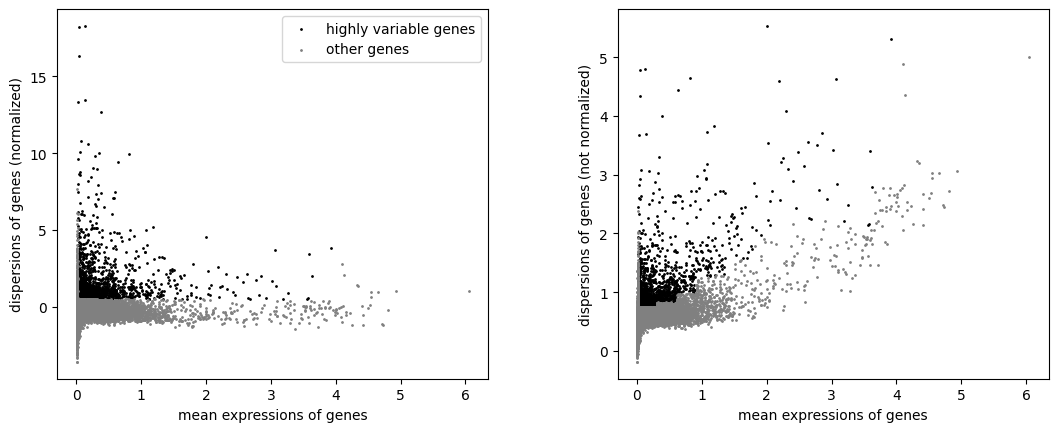

In [26]:
sc.pl.highly_variable_genes(mdata["preproc_permissive"])

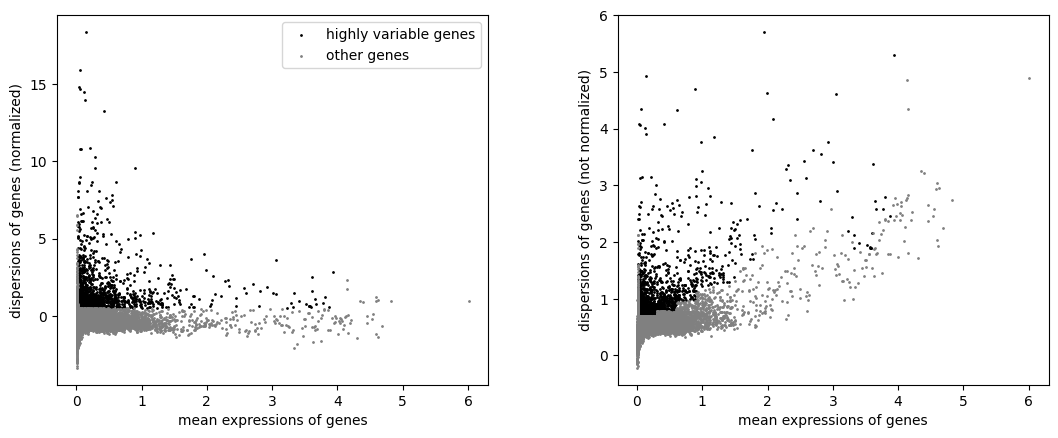

In [27]:
sc.pl.highly_variable_genes(mdata["preproc_strict"])

In [28]:
def generateEmbeddings(adata):
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
    sc.tl.umap(adata)

In [29]:
generateEmbeddings(mdata["preproc_permissive"])
sc.tl.leiden(mdata["preproc_permissive"], resolution=0.6)

/home/runner/miniconda3/envs/tutorials/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [30]:
mdata["preproc_permissive"].obs.cells_selection_alt = mdata["preproc_permissive"].obs.cells_selection_alt.astype(
    "category"
)

Look at the 2 embeddings, most of these are exactly the same cells, but as you can see, the anndata resulting from the more permissive workflow has a cluster whose `MT count %` is considerably higher compared to the rest. Remember that the filtering criteria we used was different on `%MT`.

Instead, in the more stringent workflow, there is no strong aggregation of cells by `%MT` which appears more omogeneously spread across the whole data.

Having this extra cluster could be exactly what you're looking for, because you're after a specific group of cells that are indeed marked by higher mitochondrial fraction amongst other things, but in most cases this effect is something we would like to get rid of.

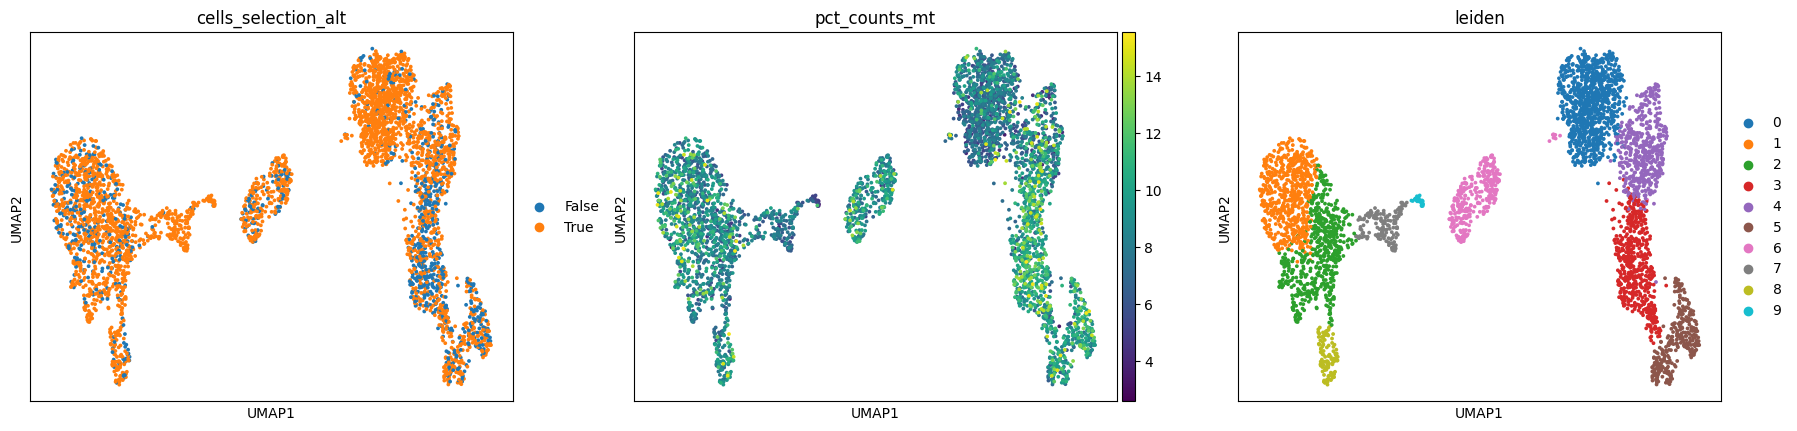

In [31]:
sc.pl.umap(mdata["preproc_permissive"], color=["cells_selection_alt", "pct_counts_mt", "leiden"])

In [32]:
generateEmbeddings(mdata["preproc_strict"])
sc.tl.leiden(mdata["preproc_strict"], resolution=0.6)

/home/runner/miniconda3/envs/tutorials/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


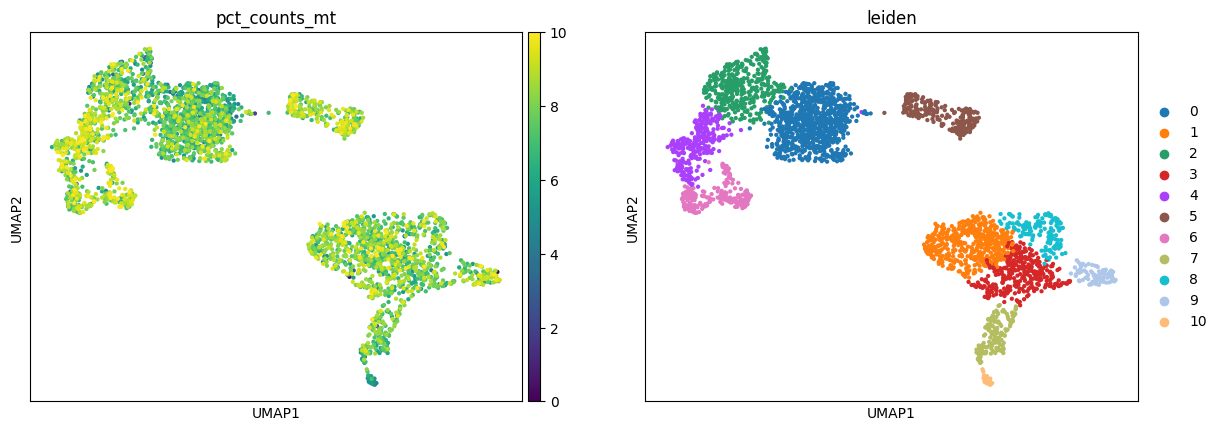

In [33]:
sc.pl.umap(mdata["preproc_strict"], color=["pct_counts_mt", "leiden"])

Another of the reasons why the 2 processing generated very different embeddings may also come down to the highly variable genes step, and as we can see at least half of the genes that are deemed HV are unique to one or another processing workflows.

In [34]:
high_var_pp1 = mdata["preproc_permissive"][:, mdata["preproc_permissive"].var.highly_variable].var_names.to_list()
high_var_pp2 = mdata["preproc_strict"][:, mdata["preproc_strict"].var.highly_variable].var_names.to_list()

In [35]:
len(list(set(high_var_pp1) & set(high_var_pp2)))

1505

# Final take home messages:

We have showcased how Mudata can help us for project management when we want to apply different processing workflows on the same data, generating different views of the same object and storing them together.

Creating the full object with either of `axis=0` or `axis=1` would introduce extra variables or observations that don't reflect the reality of the underlying data. Instead, by using the `axis=-1` convention, we were able to store different views of the same data in the final `MuData` object and observed how different workflows can have different results.

Other more advanced uses of this would include annotating the original anndata and subsetting by lineages. One could then apply different workflows on each lineage, for example, velocity analysis on only one of the generated subset, but still keep a view of the total dataset and project the newly generated information on the full object.

For now, we hope you have a clear idea of the `axes` conventions in `MuData` and that you will use this examples in your project!